In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/processed_data.csv')
# data = pd.read_csv('../data/sample_data.csv')

In [3]:
df_majority = data[data['label'] == 0]
df_minority = data[data['label'] == 1]

df_minority_oversampled = resample(df_minority, 
                                   replace=True,  # sample with replacement
                                   n_samples=len(df_majority),
                                   random_state=42)


balanced_data = pd.concat([df_majority, df_minority_oversampled])

# Shuffle the data to mix minority and majority class instances
balanced_data = balanced_data.sample(frac=1, random_state=42)

In [4]:
# Encode Sequence Data
sequence_columns = ['sequence_key', 'sequence_-1', 'sequence_0', 'sequence_+1']
label_encoder = LabelEncoder()

# Apply LabelEncoder to each sequence column
for col in sequence_columns:
    balanced_data[col] = label_encoder.fit_transform(balanced_data[col])


In [5]:
# Normalize the Numerical Features
numerical_columns = ['dwell_time_-1', 'sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 
                     'dwell_time_+1', 'sd_+1', 'mean_+1']

scaler = StandardScaler()
balanced_data[numerical_columns] = scaler.fit_transform(balanced_data[numerical_columns])


In [6]:
# Group by transcript_id to create bags
bags = balanced_data.groupby(['transcript_id'])

X_bags = []
y_bags = []

for bag_key, bag_data in bags:
    # Drop non-feature columns ('transcript_id', 'label') to get feature values
    features = bag_data.drop(columns=['transcript_id', 'label'])
    
    # Append the features for all instances in the bag
    X_bags.append(features.values)  # Each bag will have multiple instances (rows)
    
    # Use any label since all labels in the bag are same
    y_bags.append(bag_data['label'].iloc[0])

# Convert X_bags to a numpy array
X_bags_np = np.array([np.array(bag) for bag in X_bags], dtype=object)  # Object dtype due to variable lengths
y_bags_np = np.array(y_bags)

# Check the shape of the first bag and the number of bags
print(f"Number of bags: {len(X_bags_np)}")
print(f"Shape of a sample bag: {X_bags_np[0].shape}")  # (num_instances_per_bag, num_features_per_instance)

Number of bags: 121838
Shape of a sample bag: (185, 14)


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bags_np, y_bags_np, test_size=0.2, random_state=42)


In [8]:
# Get data ready
def data_generator(X_bags, y_bags, batch_size):
    num_samples = len(X_bags)
    while True:
        for offset in range(0, num_samples, batch_size):
            X_batch = X_bags[offset:offset+batch_size]
            y_batch = y_bags[offset:offset+batch_size]
            
            # Use longest sequence in the batch to pad the sequences
            max_len = max(len(bag) for bag in X_batch)
            
            # Pad the batches to the length of the longest sequence in the batch
            X_batch_padded = pad_sequences(X_batch, padding='post', dtype='float32', maxlen=max_len)
            
            # Ensure the output is shaped (batch_size, num_instances, num_features)
            yield np.array(X_batch_padded), np.array(y_batch)

In [9]:
# Get TensorFlow datasets ready using the generator
batch_size = 32

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, None, X_train[0].shape[1]), dtype=tf.float32),  # use dynamic length
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, y_test, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, None, X_test[0].shape[1]), dtype=tf.float32),  # use dynamic length
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

In [10]:
# the MIL model
def create_instance_model(input_shape):
    input_layer = layers.Input(shape=(None, input_shape))  # Variable length input
    x = layers.Dense(256, activation='relu')(input_layer) 
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x) 
    return models.Model(inputs=input_layer, outputs=output_layer)

def create_mil_model(input_shape):
    instance_model = create_instance_model(input_shape)
    
    # Input for the bag of instances (None allows for variable-length input)
    bag_input = layers.Input(shape=(None, input_shape))
    
    # Apply instance model to each instance in the bag
    instance_predictions = instance_model(bag_input)
    
    # Use Global Max Pooling to aggregate predictions across instances
    bag_prediction = layers.GlobalMaxPooling1D()(instance_predictions)
    
    mil_model = models.Model(inputs=bag_input, outputs=bag_prediction)
    return mil_model

In [11]:
# Compile the model
input_shape = X_bags_np[0].shape[1]  # num_features_per_instance

mil_model = create_mil_model(input_shape)

class_weight = {0: 1, 1: 10}  # Increase weight for 1 to handle imbalance

# Compile the model
mil_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'], )


In [12]:
# Model training
mil_model.fit(train_dataset, epochs=100, steps_per_epoch=len(X_train) // batch_size, class_weight=class_weight)


Epoch 1/100
3045/3045 [==============================] - 13s 4ms/step - loss: 1.5782 - accuracy: 0.7673
Epoch 2/100
3045/3045 [==============================] - 10s 3ms/step - loss: 1.2292 - accuracy: 0.7682
Epoch 3/100
3045/3045 [==============================] - 10s 3ms/step - loss: 1.1282 - accuracy: 0.7801
Epoch 4/100
3045/3045 [==============================] - 10s 3ms/step - loss: 1.0681 - accuracy: 0.7848
Epoch 5/100
3045/3045 [==============================] - 10s 3ms/step - loss: 1.0298 - accuracy: 0.7911
Epoch 6/100
3045/3045 [==============================] - 10s 3ms/step - loss: 0.9504 - accuracy: 0.8004
Epoch 7/100
3045/3045 [==============================] - 10s 3ms/step - loss: 0.9161 - accuracy: 0.8107
Epoch 8/100
3045/3045 [==============================] - 10s 3ms/step - loss: 0.8778 - accuracy: 0.8245
Epoch 9/100
3045/3045 [==============================] - 10s 3ms/step - loss: 0.8566 - accuracy: 0.8450
Epoch 10/100
3045/3045 [==============================] - 10s 3m

In [13]:
# Evaluate the model using the test dataset
test_loss, test_acc = mil_model.evaluate(test_dataset, steps=len(X_test) // batch_size)
print(f'Test Accuracy: {test_acc}')

761/761 [==============================] - 3s 4ms/step - loss: 0.3504 - accuracy: 0.8545
Test Accuracy: 0.8545088768005371


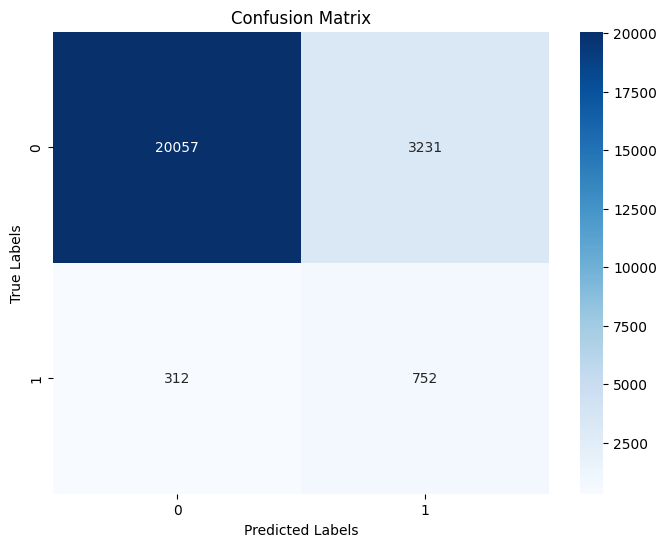

In [19]:
# Make predictions on the test dataset
y_pred_proba = mil_model.predict(test_dataset, steps=len(X_test) // batch_size) # Predicted probabilities

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test[:len(y_pred)], y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
